In [1]:
from sklearn.metrics import accuracy_score
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

import tensorflow as tf
print(tf.test.is_built_with_cuda())

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tue May 04 21:11:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.09       Driver Version: 457.09       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 206... WDDM  | 00000000:08:00.0  On |                  N/A |
|  0%   35C    P8    16W / 175W |    836MiB /  8192MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from tensorflow import expand_dims
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping


heart_list = [pd.read_csv('E:/Arrhythmia/ECG(csv)/ptbdb_'+i+'.csv') for i in ['abnormal','normal']]
for i,df in enumerate(heart_list):
    df.columns = list(range(len(df.columns)))
    heart_list[i] = df.rename({187:'Label'}, axis=1)

In [4]:
heart_list[1].head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,Label
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
heart_df = pd.concat(heart_list, axis=0).reset_index(drop=True)
heart_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,Label
0,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.925265,0.433352,0.073620,0.079197,0.136643,0.182934,0.182934,0.182376,0.196877,0.203569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14545,1.000000,0.929586,0.503550,0.293491,0.169822,0.159763,0.130769,0.125444,0.137278,0.111243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14546,1.000000,0.637579,0.154837,0.061983,0.088965,0.083374,0.065143,0.057365,0.060039,0.060039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14547,1.000000,0.872574,0.465071,0.232212,0.126132,0.155886,0.174644,0.190168,0.203752,0.168823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14548,0.915983,0.529373,0.288406,0.144536,0.171802,0.180669,0.177566,0.176458,0.178896,0.180448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
heart_df.describe

<bound method NDFrame.describe of               0         1         2         3         4         5         6  \
0      1.000000  0.606941  0.384181  0.254237  0.223567  0.276836  0.253430   
1      1.000000  0.951613  0.923963  0.853303  0.791859  0.734255  0.672043   
2      0.977819  0.899261  0.230129  0.032348  0.142329  0.223660  0.328096   
3      0.935618  0.801661  0.805815  1.000000  0.722741  0.480789  0.454829   
4      0.925265  0.433352  0.073620  0.079197  0.136643  0.182934  0.182934   
...         ...       ...       ...       ...       ...       ...       ...   
14545  1.000000  0.929586  0.503550  0.293491  0.169822  0.159763  0.130769   
14546  1.000000  0.637579  0.154837  0.061983  0.088965  0.083374  0.065143   
14547  1.000000  0.872574  0.465071  0.232212  0.126132  0.155886  0.174644   
14548  0.915983  0.529373  0.288406  0.144536  0.171802  0.180669  0.177566   
14549  1.000000  0.838643  0.390567  0.191146  0.033513  0.055854  0.129086   

              7  

In [7]:
y = heart_df['Label']
x = heart_df.drop('Label', axis=1)
print(x)
print(y)

            0         1         2         3         4         5         6    \
0      1.000000  0.606941  0.384181  0.254237  0.223567  0.276836  0.253430   
1      1.000000  0.951613  0.923963  0.853303  0.791859  0.734255  0.672043   
2      0.977819  0.899261  0.230129  0.032348  0.142329  0.223660  0.328096   
3      0.935618  0.801661  0.805815  1.000000  0.722741  0.480789  0.454829   
4      0.925265  0.433352  0.073620  0.079197  0.136643  0.182934  0.182934   
...         ...       ...       ...       ...       ...       ...       ...   
14545  1.000000  0.929586  0.503550  0.293491  0.169822  0.159763  0.130769   
14546  1.000000  0.637579  0.154837  0.061983  0.088965  0.083374  0.065143   
14547  1.000000  0.872574  0.465071  0.232212  0.126132  0.155886  0.174644   
14548  0.915983  0.529373  0.288406  0.144536  0.171802  0.180669  0.177566   
14549  1.000000  0.838643  0.390567  0.191146  0.033513  0.055854  0.129086   

            7         8         9    ...  177  178 

Text(0.5, 1.0, 'PTB Normal Arrhythmia Dataset example signal')

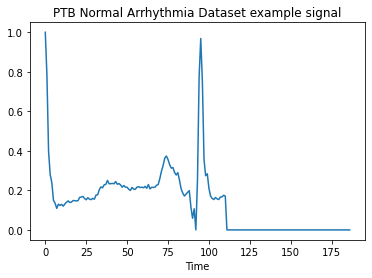

In [8]:
plt.plot(x.iloc[4000])
plt.xlabel('Time')
plt.title("Normal Arrhythmia signal")

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, random_state=6)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10185, 187), (4365, 187), (10185,), (4365,))

In [42]:
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout
inputs = Input(shape=(x_train.shape[1],))
expand = expand_dims(inputs, axis=2)

def get_model():
    lstm = LSTM(50,return_sequences=True)(expand)
    drop1 = Dropout(0.2)(lstm)
    lstm2 = LSTM(100,return_sequences=True)(drop1)
    flatten = Flatten()(lstm2)
    outputs = Dense(1, activation='sigmoid')(flatten)
    return Model(inputs=inputs, outputs=outputs)

model = get_model()
model.summary()

early_stopping_cb = EarlyStopping(monitor="val_loss",patience=15)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', AUC(name='AUC')])

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 187)]             0         
_________________________________________________________________
tf_op_layer_ExpandDims_7 (Te [(None, 187, 1)]          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 187, 50)           10400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 187, 50)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 187, 100)          60400     
_________________________________________________________________
flatten_5 (Flatten)          (None, 18700)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)               

In [43]:
model_history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=128,
    epochs=30,
    callbacks=[early_stopping_cb]
)

Epoch 1/30
80/80 [==============================] - 3s 40ms/step - loss: 0.4920 - acc: 0.7554 - AUC: 0.7739 - val_loss: 0.4250 - val_acc: 0.7826 - val_AUC: 0.8543

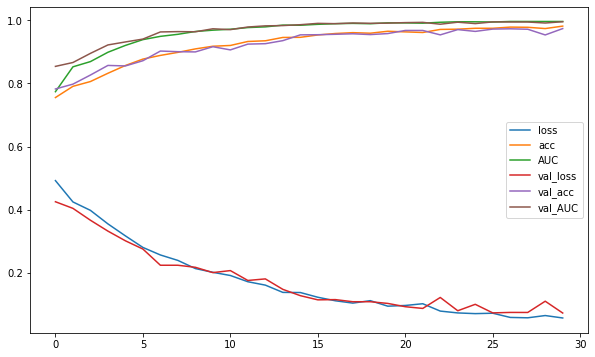

137/137 [==============================] - 2s 11ms/step - loss: 0.0721 - acc: 0.9741 - AUC: 0.9959

In [44]:
model_history.history.keys()
plt.figure(figsize=[10,6])
for key in model_history.history.keys():
    plt.plot(model_history.history[key], label=key)

plt.legend()
plt.show()

results = model.evaluate(x_test, y_test, verbose=1)

In [45]:
print("Loss: {:.2f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("Test AUC: {:.4f}".format(results[2]))

Loss: 0.07
Test Accuracy: 97.41%
Test AUC: 0.9959


In [46]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y_pred = model.predict(x_test)
test_acc = metrics.accuracy_score(y_test, y_pred.round())
cm = confusion_matrix(y_pred.round(), y_test)
print(cm)

[[1186   77]
 [  36 3066]]


In [50]:
f1 = metrics.f1_score(y_test, y_pred.round())
print("F1", f1)

recall = metrics.recall_score(y_test, y_pred.round())
print("Recall", recall)

roc = metrics.roc_auc_score(y_test, y_pred.round())
print("ROC AUC ",  roc)

precision = metrics.precision_score(y_test, y_pred.round())
print("Precision: ", precision)

F1 0.9819055244195356
Recall 0.9755011135857461
ROC AUC  0.9730206058927094
Precision:  0.988394584139265
